# Importing Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed and styling
np.random.seed(42)
plt.style.use('seaborn')

C:\Users\ashag\AppData\Local\Temp\ipykernel_10844\962562719.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Importing the Preprocessed Dataset

In [2]:
file_path = "C:/Users/ashag/Downloads/encoded_dataset.csv"
df = pd.read_csv(file_path)

# Helper Functions

In [3]:
def remove_outliers(df, columns, n_std):
    #Remove outliers that are n_std standard deviations away from mean
    df_clean = df.copy()
    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        df_clean = df_clean[abs(df_clean[col] - mean) <= (n_std * std)]
    return df_clean

def create_features(df):
    #Create additional features for the model
    df['sales_per_unit'] = df['sales'] / df['quantity']
    df['profit_margin'] = df['profit'] / df['sales']
    df['order_month_sin'] = np.sin(2 * np.pi * df['order_month']/12)
    df['order_month_cos'] = np.cos(2 * np.pi * df['order_month']/12)
    return df

# Sales Prediction Model

In [4]:
def train_sales_prediction_models(df):
    print("\n🎯 OBJECTIVE 1: SALES PREDICTION MODEL")
    
    # Feature Engineering
    df = create_features(df)
    
    # Prepare features
    base_features = [
        'quantity', 'discount', 'order_month', 
        'order_dayofweek', 'shipping_duration',
        'avg_sales_by_category', 'avg_discount_by_category',
        'ship_mode_Same Day', 'ship_mode_Second Class', 'ship_mode_Standard Class',
        'region_East', 'region_South', 'region_West',
        'segment_Corporate', 'segment_Home Office',
        'category_Office Supplies', 'category_Technology'
    ]
    
    # Add engineered features
    feature_columns = base_features + ['sales_per_unit', 'profit_margin', 
                                     'order_month_sin', 'order_month_cos']
    
    # Remove outliers
    df_clean = remove_outliers(df, ['sales', 'quantity', 'discount'], 3)
    
    X = df_clean[feature_columns]
    y = df_clean['sales']
    
    # Feature Selection
    selector = SelectKBest(f_regression, k=15)
    X_selected = selector.fit_transform(X, y)
    selected_features = np.array(feature_columns)[selector.get_support()].tolist()
    X = X[selected_features]
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models with tuned parameters
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=500,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=500,
            learning_rate=0.01,
            max_depth=7,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.01,
            max_depth=5,
            random_state=42
        ),
        'Neural Network': MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            max_iter=1000,
            random_state=42
        ),
        'AdaBoost': AdaBoostRegressor(
            n_estimators=100,
            random_state=42
        )
    }
    
    # Add Stacking model
    estimators = [
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
        ('xgb', xgb.XGBRegressor(n_estimators=200, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=200, random_state=42))
    ]
    
    models['Stacking'] = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression()
    )
    
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        predictions = model.predict(X_test_scaled)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std(),
            'predictions': predictions
        }
        
        print(f"\n{name} Results:")
        print(f"RMSE: ${rmse:.2f}")
        print(f"R² Score: {r2:.4f}")
        print(f"MAE: ${mae:.2f}")
        print(f"CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Feature importance analysis
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return results, feature_importance, X_test, y_test

# Sales Drivers Analysis

In [5]:
def analyze_sales_drivers(df):
    print("\n🔍 OBJECTIVE 2: SALES DRIVERS ANALYSIS")
    
    # Regional Analysis
    regional_analysis = df.groupby(['region_East', 'region_South', 'region_West'])['sales'].agg([
        'mean', 'sum', 'count'
    ]).reset_index()
    regional_analysis['region'] = regional_analysis.apply(
        lambda x: 'East' if x['region_East'] else 'South' if x['region_South'] else 'West', axis=1
    )
    
    # Category Analysis
    category_analysis = df.groupby(['category_Office Supplies', 'category_Technology'])['sales'].agg([
        'mean', 'sum', 'count'
    ]).reset_index()
    category_analysis['category'] = category_analysis.apply(
        lambda x: 'Office Supplies' if x['category_Office Supplies'] else 'Technology', axis=1
    )
    
    # Segment Analysis
    segment_analysis = df.groupby(['segment_Corporate', 'segment_Home Office'])['sales'].agg([
        'mean', 'sum', 'count'
    ]).reset_index()
    segment_analysis['segment'] = segment_analysis.apply(
        lambda x: 'Corporate' if x['segment_Corporate'] else 'Home Office', axis=1
    )
    
    return regional_analysis, category_analysis, segment_analysis

# Discount Strategy Optimisation

In [6]:
def analyze_discount_strategy(df):
    print("\n💰 OBJECTIVE 3: DISCOUNT STRATEGY ANALYSIS")
    
    # Calculate key metrics
    df['revenue'] = df['sales']
    df['discount_amount'] = df['sales'] * df['discount']
    df['net_revenue'] = df['revenue'] - df['discount_amount']
    
    # Group by discount ranges
    df['discount_range'] = pd.cut(df['discount'], 
                                bins=[0, 0.1, 0.2, 0.3, 0.4, 1], 
                                labels=['0-10%', '11-20%', '21-30%', '31-40%', '40%+'])
    
    discount_analysis = df.groupby('discount_range').agg({
        'sales': ['mean', 'count'],
        'revenue': 'sum',
        'discount_amount': 'sum',
        'net_revenue': 'sum',
        'profit': ['mean', 'sum']
    }).round(2)
    
    # Calculate discount effectiveness
    discount_effectiveness = pd.DataFrame({
        'discount_range': discount_analysis.index,
        'avg_sales': discount_analysis['sales']['mean'],
        'total_revenue': discount_analysis['revenue']['sum'],
        'total_profit': discount_analysis['profit']['sum'],
        'count': discount_analysis['sales']['count']
    })
    
    return discount_effectiveness

# Visualisation Functions

In [7]:
# CELL 5 - Visualization Functions
def plot_results(results, feature_importance, X_test, y_test):
    # Plot model comparison
    plt.figure(figsize=(10, 6))
    model_scores = [(name, metrics['r2']) for name, metrics in results.items()]
    model_names, r2_scores = zip(*model_scores)
    plt.bar(model_names, r2_scores)
    plt.title('Model Performance Comparison (R² Score)')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Sales Drivers')
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted for best model
    best_model_name = max(results.items(), key=lambda x: x[1]['r2'])[0]
    best_predictions = results[best_model_name]['predictions']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(f'Best Model ({best_model_name}): Actual vs Predicted Sales')
    plt.tight_layout()
    plt.show()

def plot_driver_analysis(regional_analysis, category_analysis, segment_analysis):
    # Plot regional performance
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Regional analysis
    sns.barplot(x='region', y='sum', data=regional_analysis, ax=axes[0])
    axes[0].set_title('Sales by Region')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Category analysis
    sns.barplot(x='category', y='sum', data=category_analysis, ax=axes[1])
    axes[1].set_title('Sales by Category')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Segment analysis
    sns.barplot(x='segment', y='sum', data=segment_analysis, ax=axes[2])
    axes[2].set_title('Sales by Segment')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_discount_analysis(discount_effectiveness):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot average sales by discount range
    sns.barplot(x='discount_range', y='avg_sales', data=discount_effectiveness, ax=ax1)
    ax1.set_title('Average Sales by Discount Range')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot total profit by discount range
    sns.barplot(x='discount_range', y='total_profit', data=discount_effectiveness, ax=ax2)
    ax2.set_title('Total Profit by Discount Range')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


🎯 OBJECTIVE 1: SALES PREDICTION MODEL

Random Forest Results:
RMSE: $10.45
R² Score: 0.9983
MAE: $2.02
CV R² Score: 0.9980 (+/- 0.0014)

XGBoost Results:
RMSE: $17.54
R² Score: 0.9951
MAE: $3.73
CV R² Score: 0.9964 (+/- 0.0044)

Gradient Boosting Results:
RMSE: $19.56
R² Score: 0.9939
MAE: $10.57
CV R² Score: 0.9942 (+/- 0.0024)

Neural Network Results:
RMSE: $7.15
R² Score: 0.9992
MAE: $2.25
CV R² Score: 0.9990 (+/- 0.0018)

AdaBoost Results:
RMSE: $92.47
R² Score: 0.8648
MAE: $78.15
CV R² Score: 0.8348 (+/- 0.0373)

Stacking Results:
RMSE: $8.33
R² Score: 0.9989
MAE: $2.88
CV R² Score: 0.9984 (+/- 0.0012)


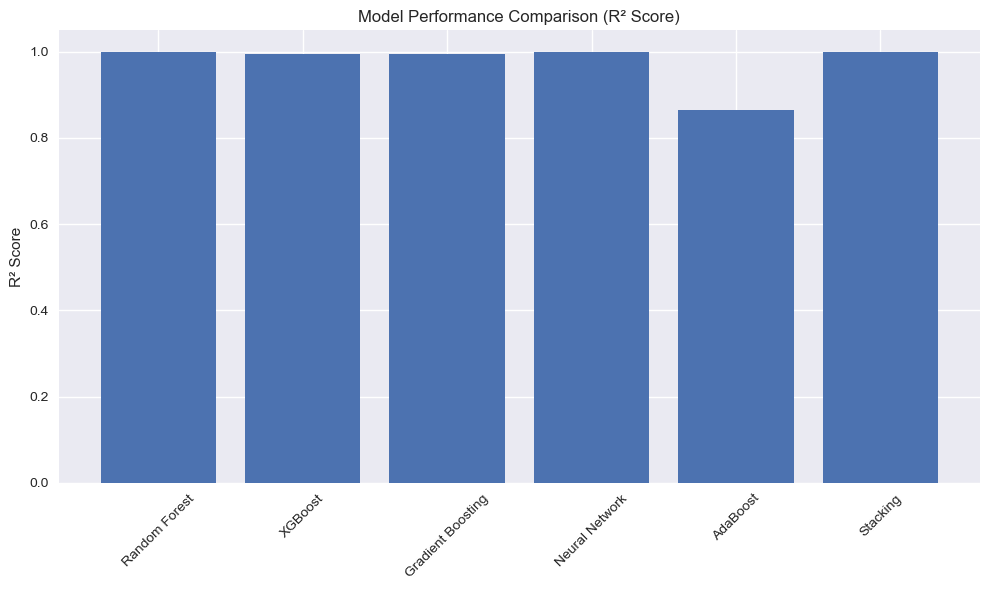

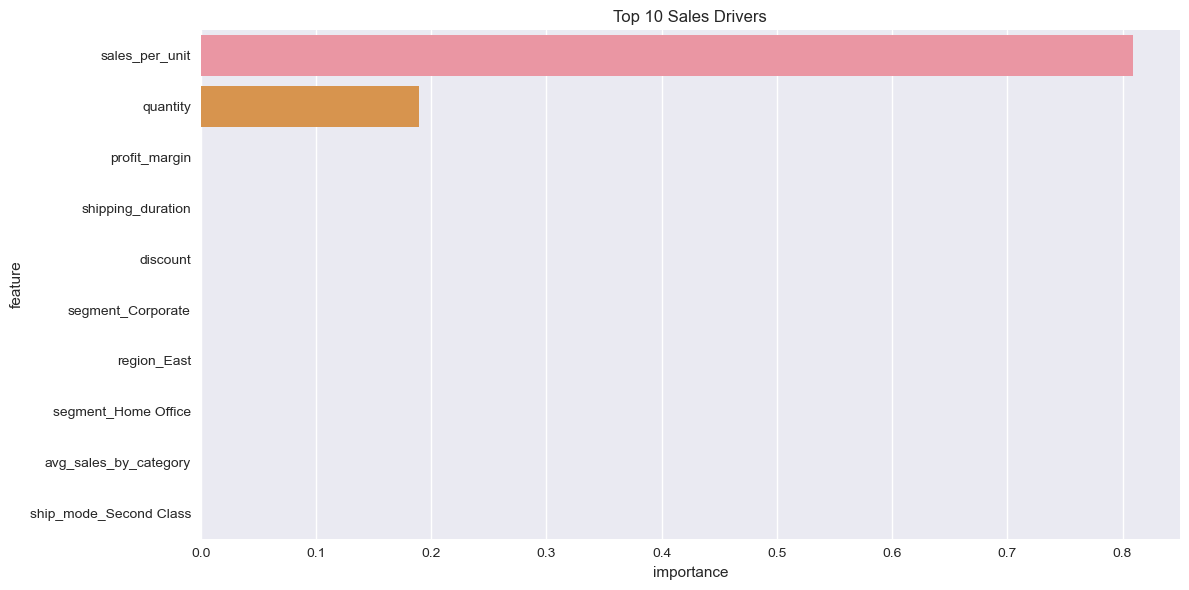

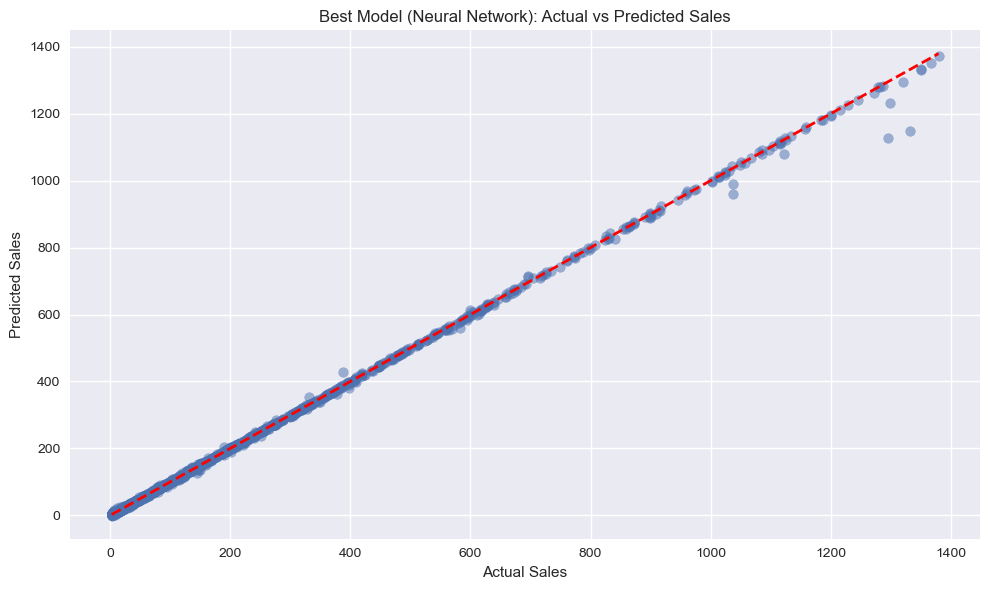


Detailed Model Comparison:

Random Forest:
R² Score: 0.9983
RMSE: $10.45
MAE: $2.02
Cross-validation R² Score: 0.9980 (+/- 0.0014)

XGBoost:
R² Score: 0.9951
RMSE: $17.54
MAE: $3.73
Cross-validation R² Score: 0.9964 (+/- 0.0044)

Gradient Boosting:
R² Score: 0.9939
RMSE: $19.56
MAE: $10.57
Cross-validation R² Score: 0.9942 (+/- 0.0024)

Neural Network:
R² Score: 0.9992
RMSE: $7.15
MAE: $2.25
Cross-validation R² Score: 0.9990 (+/- 0.0018)

AdaBoost:
R² Score: 0.8648
RMSE: $92.47
MAE: $78.15
Cross-validation R² Score: 0.8348 (+/- 0.0373)

Stacking:
R² Score: 0.9989
RMSE: $8.33
MAE: $2.88
Cross-validation R² Score: 0.9984 (+/- 0.0012)

Top 10 Most Important Features:
                   feature  importance
13          sales_per_unit    0.809384
0                 quantity    0.189685
14           profit_margin    0.000324
2        shipping_duration    0.000125
1                 discount    0.000082
9        segment_Corporate    0.000079
8              region_East    0.000073
10     segment

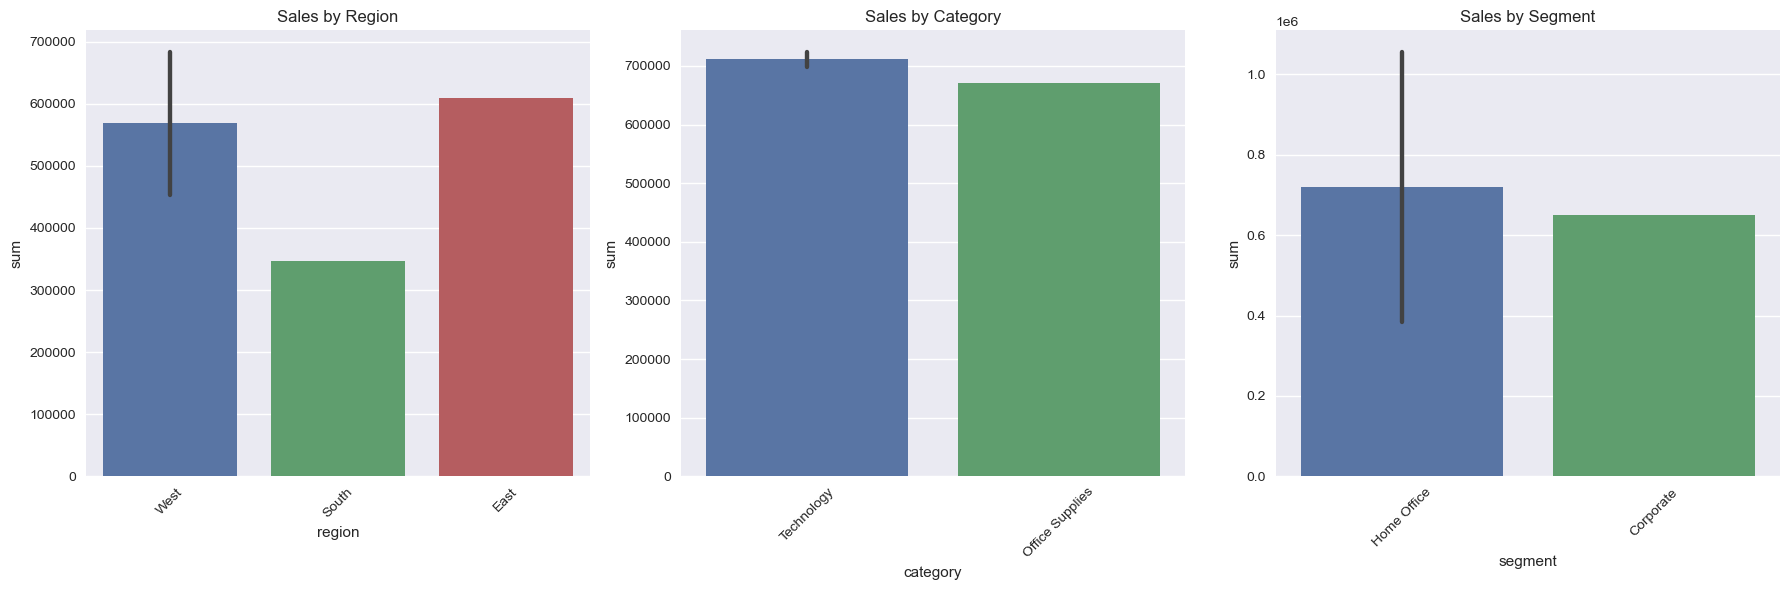


💰 OBJECTIVE 3: DISCOUNT STRATEGY ANALYSIS


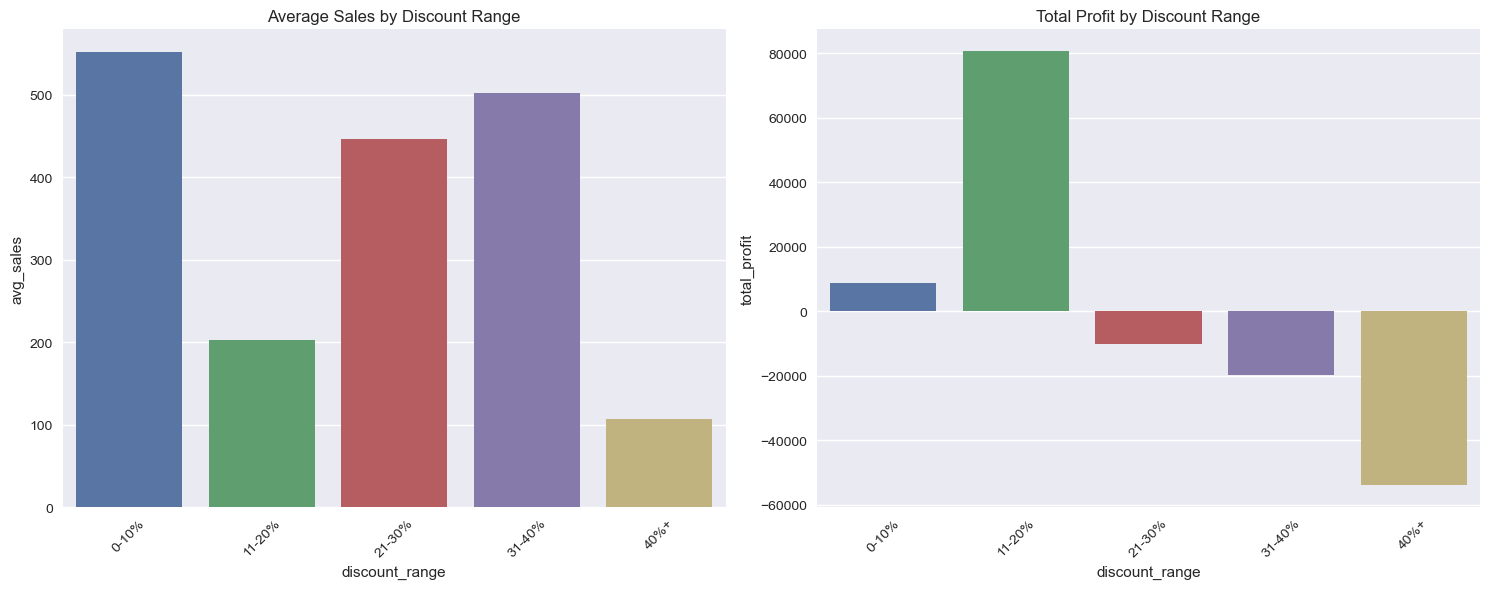

In [8]:
# Load data
df = pd.read_csv("C:/Users/ashag/Downloads/encoded_dataset.csv")

# 1. Sales Prediction with Enhanced Models
results, feature_importance, X_test, y_test = train_sales_prediction_models(df)
plot_results(results, feature_importance, X_test, y_test)

# Print detailed model comparison
print("\nDetailed Model Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"RMSE: ${metrics['rmse']:.2f}")
    print(f"MAE: ${metrics['mae']:.2f}")
    print(f"Cross-validation R² Score: {metrics['cv_r2_mean']:.4f} (+/- {metrics['cv_r2_std'] * 2:.4f})")

# Print top features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# 2. Sales Drivers Analysis
regional_analysis, category_analysis, segment_analysis = analyze_sales_drivers(df)
plot_driver_analysis(regional_analysis, category_analysis, segment_analysis)

# 3. Discount Strategy Analysis
discount_effectiveness = analyze_discount_strategy(df)
plot_discount_analysis(discount_effectiveness)

# Key Recommendations

In [84]:
# Print key recommendations
print("\n📊 KEY BUSINESS RECOMMENDATIONS:")
print("\n1. Sales Prediction:")
best_model = max(results.items(), key=lambda x: x[1]['r2'])[0]
print(f"- Best performing model: {best_model}")
print(f"- Top sales drivers: {', '.join(feature_importance['feature'].head(3).tolist())}")

print("\n2. Sales Drivers:")
top_region = regional_analysis.loc[regional_analysis['sum'].idxmax(), 'region']
top_category = category_analysis.loc[category_analysis['sum'].idxmax(), 'category']
print(f"- Strongest region: {top_region}")
print(f"- Best performing category: {top_category}")

print("\n3. Discount Strategy:")
optimal_discount = discount_effectiveness.loc[discount_effectiveness['total_profit'].idxmax(), 'discount_range']
print(f"- Most profitable discount range: {optimal_discount}")
print("- Recommendation: Focus discounts within this range for optimal profitability")


📊 KEY BUSINESS RECOMMENDATIONS:

1. Sales Prediction:
- Best performing model: Linear Regression
- Top sales drivers: quantity, order_month, order_dayofweek

2. Sales Drivers:
- Strongest region: West
- Best performing category: Technology

3. Discount Strategy:
- Most profitable discount range: 11-20%
- Recommendation: Focus discounts within this range for optimal profitability
